In [249]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [250]:
def load_sudoku(filename):
    with open(f"sudoku_boards/{filename}", "r") as file:
        return [[int(x) for x in (row[:-1] if row[-1]=='\n' else row)] for row in file.readlines()]

In [251]:
def show_sudoku(board, filled=True):
    m = 360
    d = m // 9
    img = Image.new(mode="RGB", size=(m, m), color=(176, 165, 155))
    draw = ImageDraw.Draw(img)
    for i in range(9):
        draw.line([(i*d, 0), (i*d, m)], width=1, fill=(0, 0, 0))
        draw.line([(0, i*d), (m, i*d)], width=1, fill=(0, 0, 0))

    for i in range(1, 3):
        draw.line([(3*i*d, 0), (3*i*d, m)], width=3, fill=(0, 0, 0))
        draw.line([(0, 3*i*d), (m, 3*i*d)], width=3, fill=(0, 0, 0))

    font = ImageFont.truetype("arial.ttf", 20)
    for i in range(9):
        for j in range(9):
            fill_color = 'blue' if fixed[i][j] else 'red'
            if fixed[i][j] or filled:
                draw.text((j*d + d/2.5, i*d + d/3.5), text=str(board[i][j]), font=font, fill=fill_color)
    display(img)

def plot_energy(energy):
    plt.plot([ind for ind in range(len(energy))], energy)
    plt.title("Energy plot")
    plt.show()


def plot_temperature(temperature):
    plt.plot([ind for ind in range(len(temperature))], temperature)
    plt.title("Temperature plot")
    plt.show()

In [252]:
class Square:
    def __init__(self, x, y, board):
        self.x = x
        self.y = y
        self.positions = []
        self.fill_positions(board)
        self.length = len(self.positions)

    def fill_positions(self, board):
        number = [False for _ in range(9)]
        empty_spots = []
        for i in range(self.x, self.x + 3):
            for j in range(self.y, self.y + 3):
                if fixed[i][j]:
                    number[board[i][j] - 1] = True
                else:
                    empty_spots.append((i, j))

        for i in range(9):
            if not number[i]:
                pos = empty_spots.pop()
                self.positions.append(pos)
                board[pos[0]][pos[1]] = i + 1

def initial_fill(board):
    sqr = [_ for _ in range(9)]
    square_id = 0
    t = [0, 3, 6]
    for x in t:
        for y in t:
            sqr[square_id] = Square(x, y, board)
            square_id += 1
    return sqr


In [253]:
def count_cols_and_rows(board, rows_count, columns_count):
    for i in range(9):
        for j in range(9):
            rows_count[i][board[i][j] - 1] += 1
            columns_count[j][board[i][j] - 1] += 1

def calculate_energy(rows_count, columns_count):
    energy = 0
    for i in range(9):
        for j in range(9):
            energy += rows_count[i][j] - 1 if rows_count[i][j] > 0 else 0
            energy += columns_count[i][j] - 1 if columns_count[i][j] > 0 else 0
    return energy

In [254]:
def swap_nums(board, pos1, pos2, rows_count, columns_count):
    num1 = board[pos1[0]][pos1[1]]
    num2 = board[pos2[0]][pos2[1]]

    board[pos1[0]][pos1[1]], board[pos2[0]][pos2[1]] = board[pos2[0]][pos2[1]], board[pos1[0]][pos1[1]]

    rows_count[pos1[0]][num1 - 1] -= 1
    columns_count[pos1[1]][num1 - 1] -= 1
    rows_count[pos2[0]][num2 - 1] -= 1
    columns_count[pos2[1]][num2 - 1] -= 1

    rows_count[pos2[0]][num1 - 1] += 1
    columns_count[pos2[1]][num1 - 1] += 1
    rows_count[pos1[0]][num2 - 1] += 1
    columns_count[pos1[1]][num2 - 1] += 1


def neighbor(board, squares, rows_count, columns_count):
    square_id = np.random.randint(0, 9)
    square = squares[square_id]
    m = square.length
    a = np.random.randint(0, m - 1)
    b = np.random.randint(a + 1, m)
    pos1 = square.positions[a]
    pos2 = square.positions[b]
    swap_nums(board, pos1, pos2, rows_count, columns_count)
    return pos1, pos2

In [255]:
def f(delta, T):
    return np.exp(-delta/T)

In [317]:
def annealing(board, T0 = 100, alpha = 0.99, steps=10000, no_of_iter=10, max_iter = 10):
    show_sudoku(board, filled=False)
    squares = initial_fill(board)
    columns_count = [[0 for _ in range(9)] for _ in range(9)]
    rows_count = [[0 for _ in range(9)] for _ in range(9)]
    count_cols_and_rows(board, rows_count, columns_count)

    cur_energy = calculate_energy(rows_count, columns_count)
    energy_states = [cur_energy]


    T = T0
    temperature = [T]
    stop = False
    iter_so_far = 0
    while not stop and iter_so_far < max_iter:
        for i in range(steps):
            for _ in range(no_of_iter):
                change = neighbor(board, squares, rows_count, columns_count)
                next_energy = calculate_energy(rows_count, columns_count)
                if next_energy < cur_energy:
                    cur_energy = next_energy
                else:
                    probability = f(next_energy - cur_energy, T)
                    if probability > np.random.uniform(0, 1):
                        cur_energy = next_energy
                    else:
                        swap_nums(board, change[0], change[1], rows_count, columns_count)
                energy_states.append(cur_energy)
                if cur_energy == 0:
                    stop = True
                    break
            T *= alpha
            temperature.append(T)
            if stop:
                break
        iter_so_far += 1
        T = T0 / iter_so_far
        print(iter_so_far, cur_energy)

    show_sudoku(board)
    plot_energy(energy_states)
    plot_temperature(temperature)

In [326]:
sudoku = load_sudoku("sudoku_nondeterministic")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

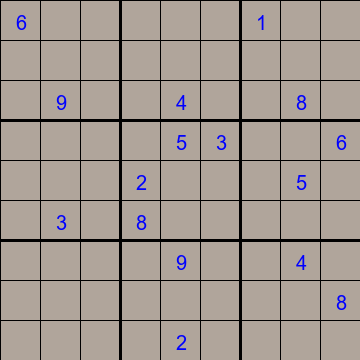

1 0


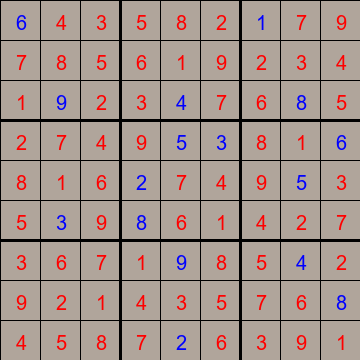

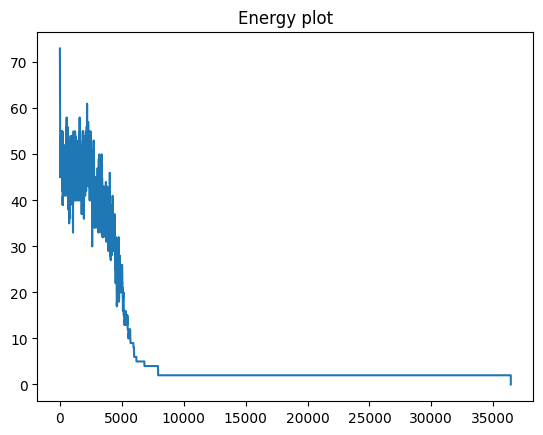

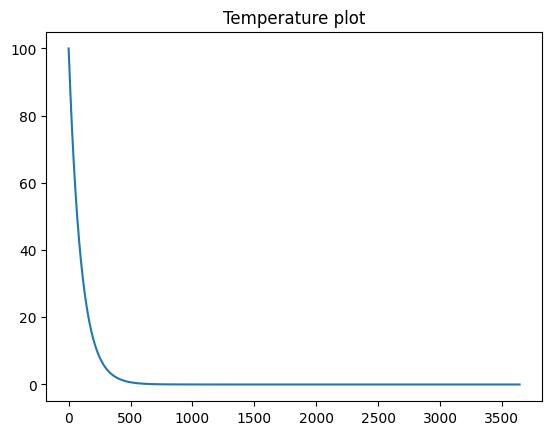

In [327]:
annealing(sudoku, max_iter=100)